In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from keras.preprocessing.text import Tokenizer

In [47]:
df = pd.read_csv('sentiment_final.csv')

In [48]:
df.sentiment.value_counts()

Negative    8493
Positive    2236
Name: sentiment, dtype: int64

In [49]:
df["text"].isnull().sum()

0

In [50]:
## how many words are there in each tweet
max([len(x.split(" ")) for x in df.text])

33

In [51]:
!pip install autocorrect
!pip install nlpaug

In [52]:
import re
from autocorrect import Speller
spell = Speller(lang='en')

def depure_data(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
    # Remove new line characters
    data = re.sub('\s+', ' ', data)
    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    data = data.lower()
    data = re.sub('rt ', '', data)
    data = re.sub('\#\S+ ', '', data)
    data = re.sub('\#\S+', '', data)
    data = re.sub('\d+ ', '', data)
    data = re.sub('&\S+', '', data)
    data = re.sub('\.', '', data)
    data = re.sub('\:', '', data)
    data = re.sub('\!', '', data)
    data = re.sub('\s\s+', ' ', data)
    data = ''.join([i if ord(i) < 128 else ' ' for i in data])
    # data = spell.autocorrect_sentence(data)
    return data

## Reduced dataset

In [ ]:
neg_sentiment = df.text.to_numpy()[np.where(df.sentiment.to_numpy() == 'Negative')[0]]
pos_sentiment = df.text.to_numpy()[np.where(df.sentiment.to_numpy() == 'Positive')[0]]
print(len(neg_sentiment), len(pos_sentiment))

reduced_neg_sentiment = np.random.choice(neg_sentiment, len(pos_sentiment))
print(len(reduced_neg_sentiment), len(pos_sentiment))
data = np.concatenate([reduced_neg_sentiment, pos_sentiment])
print(data.shape)
target_n = np.array(['Negative']*len(reduced_neg_sentiment))
target_p = np.array(['Positive']*len(pos_sentiment))
target = np.concatenate([target_n, target_p])
df = pd.DataFrame({'text': data, 'sentiment': target})
df

8493 2236
2236 2236
(4472,)


,text,sentiment
0,"So last night,\n#JonVoyage full of honesty and...",Negative
1,I did watch all 2nd string #GOPDebate ... can ...,Negative
2,"RT @FatCatColleen: ""Maybe if I just keep bring...",Negative
3,An assassination attempt ...now GOP has to de...,Negative
4,RT @RWSurferGirl: I'd really like to see how l...,Negative
...,...,...
4467,"Best line of #GOPDebate was ""Immigration witho...",Positive
4468,"RT @RWSurferGirl: Trump has got it right, nobo...",Positive
4469,RT @georgehenryw: Who thought Huckabee exceede...,Positive
4470,"RT @Lrihendry: #TedCruz As President, I will a...",Positive


## Expanded dataset

In [53]:
data = df.text
clean_data = data.apply(depure_data)
clean_data[50]

'before the focus groupers said they had favorable view of trump after, only saw him positively '

In [54]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import nlpaug
import nlpaug.augmenter.word as naw
aug = naw.SynonymAug(aug_src='wordnet',aug_max=5)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
class_neg = clean_data.where(df.sentiment == 'Negative').dropna()
class_pos = clean_data.where(df.sentiment == 'Positive').dropna()
augmented = []
for d in class_pos:
  res = aug.augment(d,n=3)
  augmented += res

augmented += class_pos.to_list()

In [43]:
len(augmented)

8944

In [44]:
new_data = class_neg.to_list() + augmented
labels = ['Negative']*len(class_neg.to_list()) + ['Positive']*len(augmented)

In [45]:
dataset = pd.DataFrame({'text': new_data, 'sentiment': labels})

In [58]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.sentiment.value_counts()

Positive    8944
Negative    8493
Name: sentiment, dtype: int64

In [59]:
clean_data = dataset.text

In [60]:
tokenizer = Tokenizer(num_words=1000, lower=True,split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(clean_data)
enc_data = tokenizer.texts_to_sequences(clean_data)
enc_data = pad_sequences(enc_data, maxlen=35)

In [61]:
vocab_size = len(tokenizer.word_counts.keys())
vocab_size

11504

In [62]:
## Prepare Labels
target = dataset.sentiment
labels = target.replace('Positive', 1)
labels = labels.replace('Negative', 0)
labels = tf.keras.utils.to_categorical(labels, 2, dtype="float32")

In [ ]:
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

smt = SMOTE(random_state=95, k_neighbors=3)
X, y = smt.fit_resample(enc_data, labels)
y = tf.keras.utils.to_categorical(y, 2, dtype="float32")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [63]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(enc_data, labels, random_state=95, test_size=0.2)
len(X_train),len(X_test),len(y_train),len(y_test)

(13949, 3488, 13949, 3488)

In [64]:
a = np.argmax(y_train, axis=1)
a.sum()/len(a)

0.5126532367911678

In [65]:
model = Sequential()
model.add(layers.Embedding(vocab_size + 1, 256, input_length=35))
model.add(layers.LSTM(128 ,dropout=0.5, unroll=True))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("weight.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.1,callbacks=[checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 256)           2945280   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 3,150,786
Trainable params: 3,150,786
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
393/393 [==============================] - 64s 71ms/step - loss: 0.5506 - accuracy: 0.6933 - val_loss: 0.3912 - val_accuracy: 0.8208

Epoch 00001: val_loss improved from inf to 0.39117, saving model to weight.h5
Epoch 2/30
393/393 [=

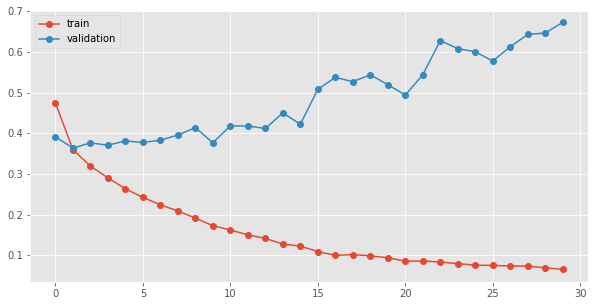

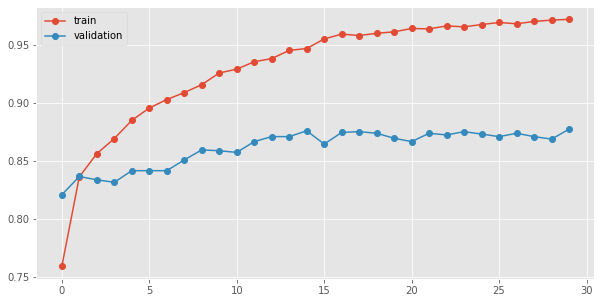

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], '-o')
plt.plot(history.history['val_loss'], '-o')
plt.legend(['train', 'validation'])
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], '-o')
plt.plot(history.history['val_accuracy'], '-o')
plt.legend(['train', 'validation'])
plt.show()

In [67]:
model_test = Sequential()
model_test.add(layers.Embedding(vocab_size + 1, 256, input_length=35))
model_test.add(layers.LSTM(128 ,dropout=0.5, unroll=True))
model_test.add(layers.Dense(64, activation='relu'))
model_test.add(layers.Dense(2, activation='softmax'))
model_test.load_weights("weight.h5")

[]

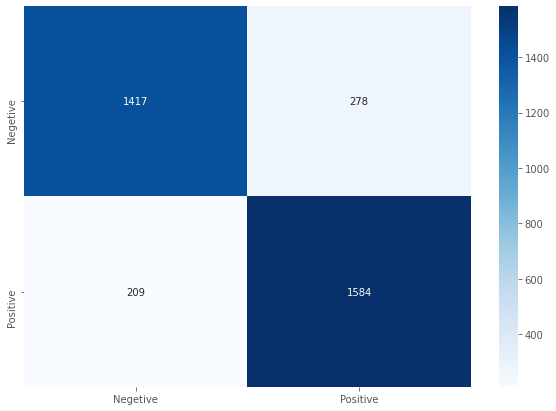

In [68]:
best = False
data = len(y_test) - 2
pred = None
if best:
  pred = model_test.predict(X_test)
else:
  pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = ['Negetive', 'Positive'],
                  columns = ['Negetive', 'Positive'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
plt.plot()

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names= ['Negetive', 'Positive']))

              precision    recall  f1-score   support

    Negetive       0.87      0.84      0.85      1695
    Positive       0.85      0.88      0.87      1793

    accuracy                           0.86      3488
   macro avg       0.86      0.86      0.86      3488
weighted avg       0.86      0.86      0.86      3488

